In [39]:
random_state = 198
contamination = 0.02

In [ ]:
import os
import pandas as pd
import numpy as np
#insa = pd.read_csv('/Users/lehuyen/Dropbox/Stage_data/insa_all.csv', header=0, delimiter=",",decimal=',')
df= pd.read_csv('/Users/NhatMinh/Desktop/ML/Stage_data/insa_all.csv')
df.columns =['Time','CPU','MEM','REC', 'TRAN','Status']
assert len(df.Time.unique())==df.shape[0] # assure that Time has not double
assert len(df.index.unique())==df.shape[0]

In [3]:
df.dtypes

Time       object
CPU       float64
MEM       float64
REC       float64
TRAN      float64
Status    float64
dtype: object

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = df.drop(['Time'], axis=1)
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.head()
df_scaled = df_scaled.fillna(df_scaled.mean())

In [16]:
df_scaled.isna().sum()

CPU       0
MEM       0
REC       0
TRAN      0
Status    0
dtype: int64

# Isolation forest

In [5]:
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [17]:
clf = IsolationForest(behaviour='new', max_samples=100,
                      random_state=147, contamination=0.02)
# contamination = 0.02 says that we fixed 2% of outliers 
clf.fit(df_scaled)
y_pred_train = clf.predict(df_scaled)

In [25]:
-sum(y_pred_train[y_pred_train==-1])/len(y_pred_train)

0.020016339869281044

In [30]:
df_scaled['isolation_forest'] = (-y_pred_train+1)/2 # 0 for normal, 1 for anomaly

In [31]:
df_scaled.head()

,CPU,MEM,REC,TRAN,Status,is_outlier_by_isolation_forest,isolation_forest
0,0.443705,0.442748,0.002434,0.000245,0.0,0.0,0.0
1,0.183978,0.489504,0.002218,0.000242,0.0,0.0,0.0
2,0.172845,0.437977,0.002803,0.000260,0.0,0.0,0.0
3,0.219213,0.400763,0.000866,0.001027,0.0,0.0,0.0
4,0.298175,0.531489,0.024543,0.001106,0.0,0.0,0.0


In [34]:
index_of_anomalies_by_isolation_forest = df_scaled[df_scaled.isolation_forest==1].index
len(index_of_anomalies_by_isolation_forest)

245

In [35]:
index_of_anomalies_by_isolation_forest

Int64Index([   82,   112,   352,   382,   602,   603,   682,   712,   813,
             1012,
            ...
            11572, 11580, 11782, 11812, 11837, 11872, 12082, 12112, 12121,
            12124],
           dtype='int64', length=245)

## Using PCA to visualizer the result

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df_scaled)
df_scaled_transform = pca.transform(df_scaled)

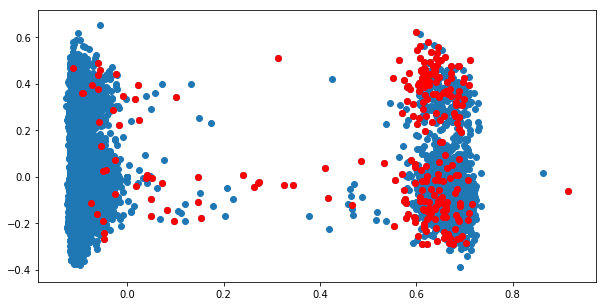

In [22]:
plt.figure(figsize=(10,5))
plt.scatter(df_scaled_transform[:,0], df_scaled_transform[:,1])
#plt.plot([1,2,3], [3,4,5])
outliers = df_scaled_transform[y_pred_train==-1]
plt.scatter(outliers[:,0], outliers[:,1], color='red')
plt.show()

In [59]:
pca.explained_variance_ratio_

array([0.49767754, 0.30052241])

With 2 dimensional reduction, we get also 79.7% of variance, which is a good PCA. This method give a good visualization for our model.
 However, we see that our data separate clearly in 2 groups, and have a particular  geometric form. We must to find a method that is more convenient for this data.

# Method ElipticEnvelope-Method using Mahanalobis metric

/anaconda3/lib/python3.7/site-packages/sklearn/covariance/robust_covariance.py:646: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


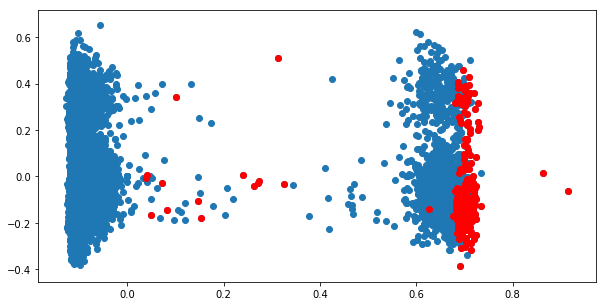

In [40]:
from sklearn.covariance import EllipticEnvelope
cov = EllipticEnvelope(random_state=random_state, contamination=contamination).fit(df_scaled)
y_pred_train_ellipticEnvelope = cov.predict(df_scaled)

plt.figure(figsize=(10,5))
plt.scatter(df_scaled_transform[:,0], df_scaled_transform[:,1])
#plt.plot([1,2,3], [3,4,5])
outliers = df_scaled_transform[y_pred_train_ellipticEnvelope==-1]
plt.scatter(outliers[:,0], outliers[:,1], color='red')
plt.show()

In [42]:
df_scaled['Eliptic_Envelope'] = (-y_pred_train_ellipticEnvelope+1)/2 # 0 for normal, 1 for anomaly
index_of_anomalies_by_Eliptic_Envolope = df_scaled[df_scaled.Eliptic_Envelope==1].index
len(index_of_anomalies_by_Eliptic_Envolope)

245

# Nearest Neighhors

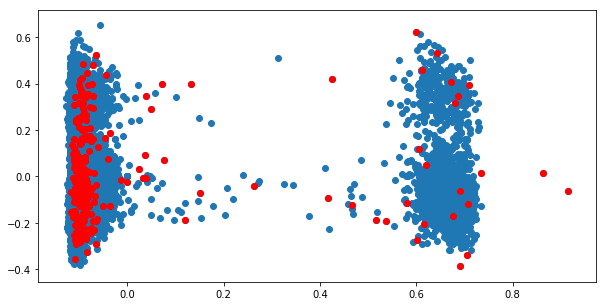

In [43]:
from sklearn.neighbors import LocalOutlierFactor
neigh = LocalOutlierFactor(n_neighbors=3, contamination=contamination)
y_pred_train_neigh = neigh.fit_predict(df_scaled)
#y_pred_train_neigh = neigh.predict(df_scaled)

plt.figure(figsize=(10,5))
plt.scatter(df_scaled_transform[:,0], df_scaled_transform[:,1])
outliers = df_scaled_transform[y_pred_train_neigh==-1]
plt.scatter(outliers[:,0], outliers[:,1], color='red')
plt.show()

In [44]:
df_scaled['Nearest_Neighbors'] = (-y_pred_train_neigh+1)/2 # 0 for normal, 1 for anomaly
index_of_anomalies_by_Nearest_Neighbors = df_scaled[df_scaled.Nearest_Neighbors==1].index
len(index_of_anomalies_by_Nearest_Neighbors)

245

# To see how the method work on the data tranform( train and predict on the data set of 2 dimension)

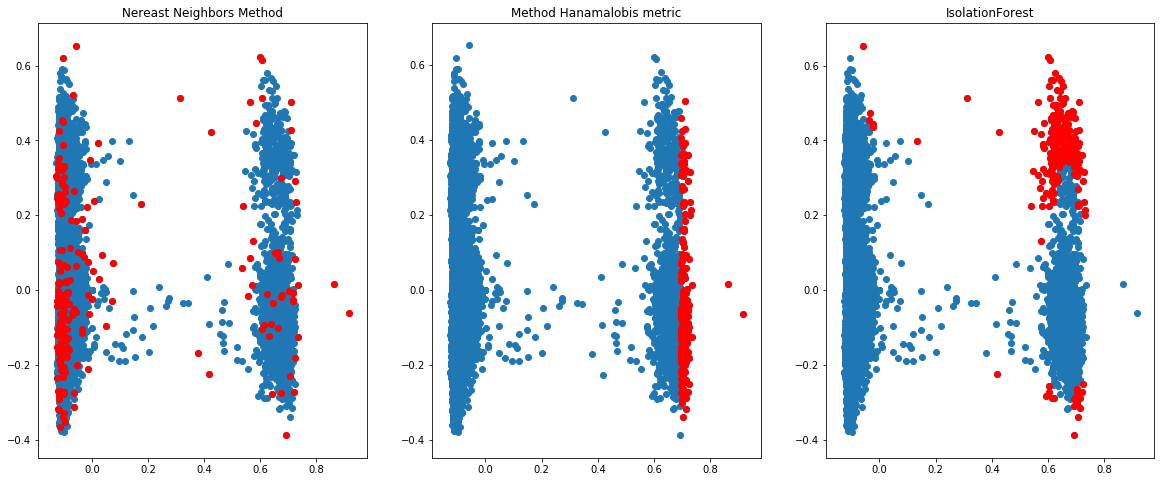

In [45]:
neigh = LocalOutlierFactor(n_neighbors=3, contamination=0.02)
y_pred_train_neigh = neigh.fit_predict(df_scaled_transform)


plt.figure(figsize=(20,8))
plt.subplot(131)
plt.scatter(df_scaled_transform[:,0], df_scaled_transform[:,1])
outliers = df_scaled_transform[y_pred_train_neigh==-1]
plt.scatter(outliers[:,0], outliers[:,1], color='red')
plt.title('Nereast Neighbors Method')

cov = EllipticEnvelope(random_state=random_state, contamination=contamination).fit(df_scaled_transform)
y_pred_train_ellipticEnvelope = cov.predict(df_scaled_transform)
plt.subplot(132)
plt.scatter(df_scaled_transform[:,0], df_scaled_transform[:,1])
#plt.plot([1,2,3], [3,4,5])
outliers = df_scaled_transform[y_pred_train_ellipticEnvelope==-1]
plt.scatter(outliers[:,0], outliers[:,1], color='red')
plt.title('Method Hanamalobis metric')

clf = IsolationForest(behaviour='new', max_samples=100,
                      random_state=147, contamination=0.02)
clf.fit(df_scaled_transform)
y_pred_train = clf.predict(df_scaled_transform)
plt.subplot(133)
plt.scatter(df_scaled_transform[:,0], df_scaled_transform[:,1])
outliers = df_scaled_transform[y_pred_train==-1]
plt.scatter(outliers[:,0], outliers[:,1], color='red')
plt.title('IsolationForest')

plt.show()